In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import read_csv, pivot_table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [4]:
data['first_party'].value_counts()

first_party
United States       154
Illinois              9
Maryland              8
Florida               8
New York              7
                   ... 
David Carpenter       1
Larry Gene Heath      1
PGA TOUR, Inc.        1
PPL Montana, LLC      1
Markman               1
Name: count, Length: 2110, dtype: int64

In [6]:
data['second_party'].value_counts()

second_party
United States                        240
California                            19
United States of America              15
Illinois                              13
Federal Communications Commission     10
                                    ... 
David Boren, Governor of Oklahoma      1
Federal Bureau of Prisons et al.       1
Town of Harrison                       1
Charles Burr et al.                    1
Westview Instruments, Inc.             1
Name: count, Length: 1974, dtype: int64

In [7]:
pd.set_option("display.max_columns", None)  # 모든 열 표시
pd.set_option("display.width", None)  # 줄 바꿈 없이 전체 내용 표시
data['facts']

0       On June 27, 1962, Phil St. Amant, a candidate ...
1       Ramon Nelson was riding his bike when he suffe...
2       An Alabama state court convicted Billy Joe Mag...
3       Victor Linkletter was convicted in state court...
4       On April 24, 1953 in Selma, Alabama, an intrud...
                              ...                        
2473    Congress amended the Clean Air Act through the...
2474    Alliance Bond Fund, Inc., an investment fund, ...
2475    In 1992, the District Court sentenced Manuel D...
2476    On March 8, 1996, Enrico St. Cyr, a lawful per...
2477    Herbert Markman owns the patent to a system th...
Name: facts, Length: 2478, dtype: object

In [9]:
data.iloc[1]['facts']

'Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circuit

In [10]:
data.iloc[0]['facts']

'On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather t

In [11]:
len(data[data['first_party_winner'] == 0].value_counts())

829

In [12]:
len(data[data['first_party_winner'] == 1].value_counts())

1649

In [14]:
# 다운샘플링
from sklearn.utils import resample

subset0 = data[data['first_party_winner'] == 0]
subset1 = data[data['first_party_winner'] == 1]

downsampled = resample(subset1,
                       replace=False,
                       n_samples=800,
                       random_state=40)
data = pd.concat([subset0, downsampled])
data

,ID,first_party,second_party,facts,first_party_winner
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
14,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",Named plaintiff James Thole and others brought...,0
16,TRAIN_0016,Plyler,Doe,A revision to the Texas education laws in 1975...,0
21,TRAIN_0021,Bassam Yacoub Salman,United States,Maher Kara joined Citigroup’s healthcare inves...,0
...,...,...,...,...,...
2368,TRAIN_2368,United States,"W.M. Webb, Inc., et al.",W.M. Webb and other commercial fishing compani...,1
1969,TRAIN_1969,"Margaret Mae Cantrell, et al.","Forest City Publishing Company, et al.","In December 1967, the Silver Bridge at Point P...",1
1077,TRAIN_1077,Federal Energy Regulatory Commission,"Electric Power Supply Association, et al.",The Federal Power Act (FPA) grants the Federal...,1
1900,TRAIN_1900,Roviaro,United States,"On August 12, 1954, agents of the Federal Bure...",1


In [15]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers.tokenization_utils import TruncationStrategy

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('averaged_perceptron_tageer')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading averaged_perceptron_tageer: Package
[nltk_data]     'averaged_perceptron_tageer' not found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
porter = PorterStemmer()

def stem_text_func(text):
    token_words=word_tokenize(text)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
        return "".join(stem_sentence)

In [17]:
from stop_words import get_stop_words 

languages = ['English']
my_stop_word_list = []
for i in languages:
    my_stop_word_list.append(get_stop_words(i.lower()))
my_stop_word_list = sum(my_stop_word_list, [])
my_stop_word_list = my_stop_word_list + ['paperbook', 'hardcover']

In [18]:
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [20]:
import re

def preprocessiong_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()
    sentence = re.sub(r'\([^)]*\)', ' ', sentence)
    sentence = re.sub('"', ' ', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b", " ", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    if my_stop_word_list :
        tokens = ' '.join(word for word in sentence.split() if not word in my_stop_word_list if len(word)>1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens

In [21]:
data['facts'] = [preprocessiong_sentence(i) for i in data['facts']]
test['facts'] = [preprocessiong_sentence(i) for i in test['facts']]

In [22]:
data['facts'] = data['facts'].astype('str')
test['facts'] = test['facts'].astype('str')

In [23]:
facts_corpus_lose = ' '.join(data[data['first_party_winner']== 0]['facts'])
facts_corpus_win = ' '.join(data[data['first_party_winner'] == 1]['facts'])

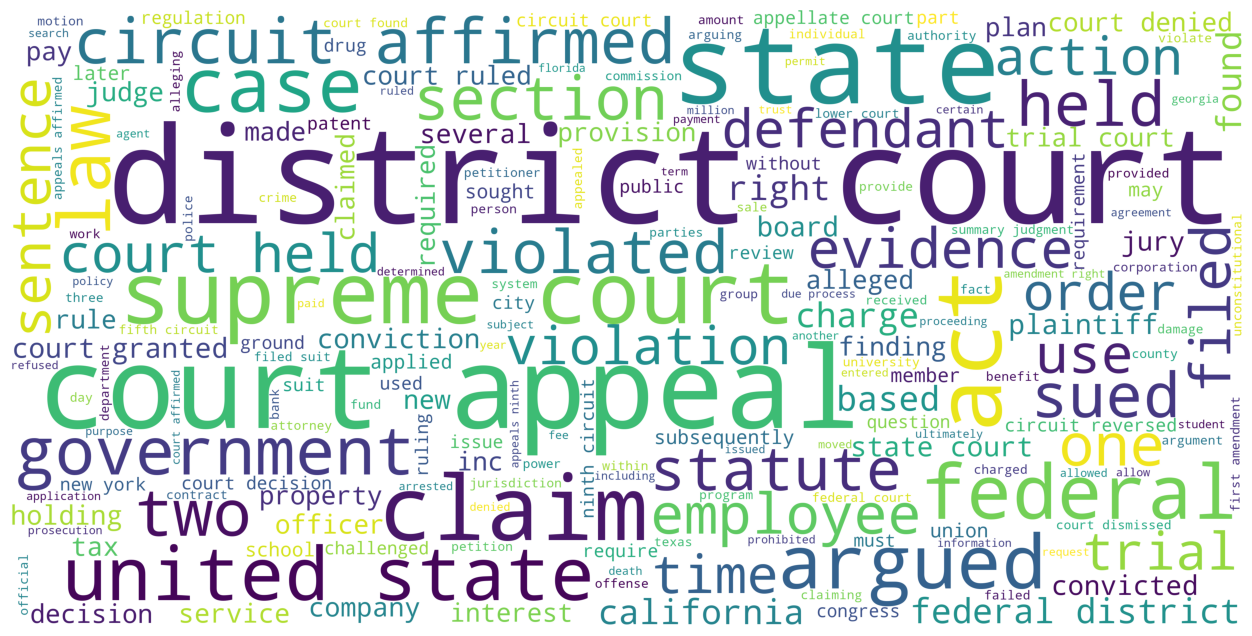

In [26]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(facts_corpus_lose)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

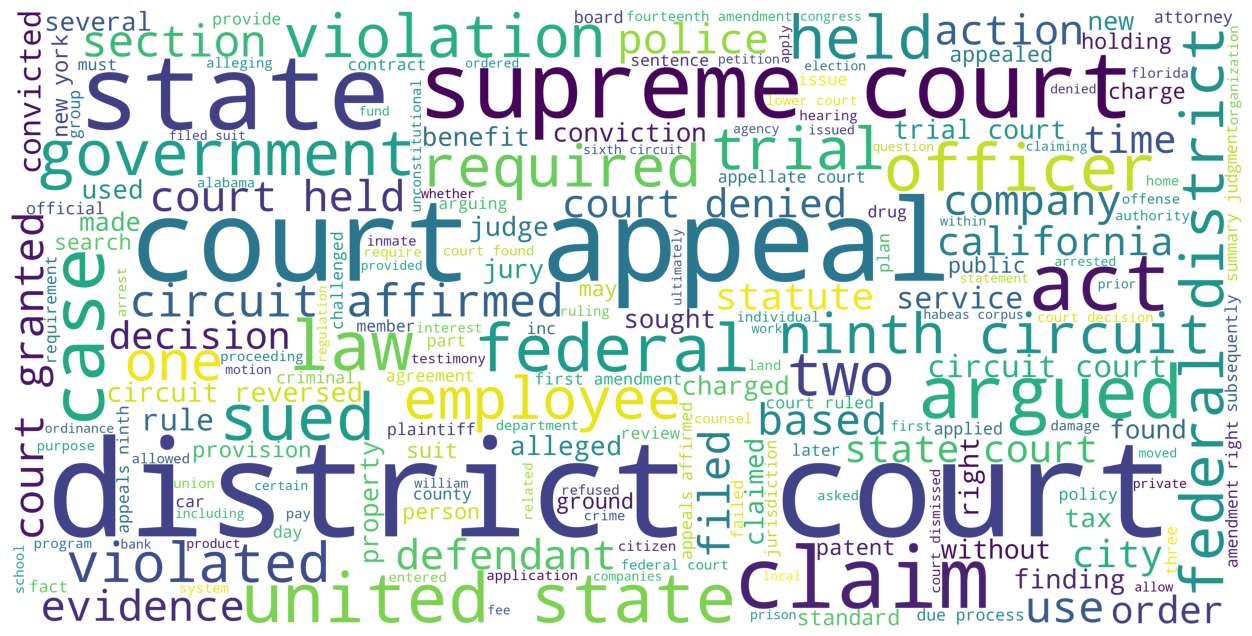

In [27]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(facts_corpus_win)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [29]:
X = get_vector(vectorizer, data, True)
Y = data['first_party_winner']
X_T = get_vector(vectorizer, test, False)

In [30]:
X = np.squeeze(np.asarray(X))
X_T = np.squeeze(np.asarray(X_T))

In [31]:
print(X.shape)

(1629, 40587)


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

In [34]:
cat_params = {
    'verbose' : 100,
    'random_state':113
}

In [35]:
from sklearn import svm
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier


# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
]

In [36]:
import time
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [37]:
score(X_train, y_train, X_test, y_test, names = names, models = models)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, a

,Classifier,Training accuracy,Validation accuracy
4,Random Forest,1.000000,0.567485
3,Linear SVM,0.999233,0.552147
7,XGBoost,1.000000,0.549080
2,Decision Tree,1.000000,0.536810
5,SGD Classifier,1.000000,0.536810
6,Ridge Classifier,1.000000,0.533742
1,KNN Classifier,0.558711,0.530675
0,Logistic Regression,0.986953,0.512270
8,AdaBoost,0.753645,0.509202


In [41]:
clf = RidgeClassifier(random_state=113)
clf.fit(X_train, y_train)

RidgeClassifier(random_state=113)

In [42]:
from sklearn.metrics import accuracy_score
y_val_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_val_pred))

0.5337423312883436


In [43]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1303, 40587) (1303,) (326, 40587) (326,)


In [44]:
sub = pd.read_csv('submission.csv')
sub['first_party_winner'] = clf.predict(X_T)
sub

,ID,first_party_winner
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,1
...,...,...
1235,TEST_1235,0
1236,TEST_1236,1
1237,TEST_1237,0
1238,TEST_1238,0


In [45]:
sub['first_party_winner'].value_counts()

first_party_winner
0    625
1    615
Name: count, dtype: int64